In [1]:
# Dependency errors in Sagemaker. Re-install
# !pip install boto3==1.17.106 s3fs pandas==1.3.5
# !pip3 install numpy --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import boto3

import warnings

warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 50)

## Data Loading

In [3]:
bucket = 's3://ads508-imdb-data'

names = pd.read_csv(f'{bucket}/ImdbName.csv', low_memory=False)
akas = pd.read_csv(f'{bucket}/ImdbTitleAkas.csv', low_memory=False)
titles = pd.read_csv(f'{bucket}/ImdbTitleBasics.csv', low_memory=False)
crew = pd.read_csv(f'{bucket}/ImdbTitleCrew.csv', low_memory=False)
episode = pd.read_csv(f'{bucket}/ImdbTitleEpisode.csv', low_memory=False)
principals = pd.read_csv(f'{bucket}/ImdbTitlePrincipals.csv', low_memory=False)
ratings = pd.read_csv(f'{bucket}/ImdbTitleRatings.csv', low_memory=False)
plots = pd.read_csv(f'{bucket}/movies_plots.csv', low_memory=False)
netflix = pd.read_csv(f'{bucket}/NetFlix.csv', low_memory=False)

In [4]:
names.shape, akas.shape, titles.shape, crew.shape, episode.shape, principals.shape, ratings.shape, plots.shape, netflix.shape

((1048575, 6),
 (1048575, 8),
 (1048575, 9),
 (1048575, 3),
 (5652641, 4),
 (1048575, 6),
 (1048575, 3),
 (46014, 21),
 (7787, 12))

#### NOTES

1. The **plots** dataframe contains additional features such as plot and awards


#### TODO (as we progress)

1. Because we don't want to recommend movies that Netflix already has, we have to check if what we have appear in their dataset. However, because there is no direct mapping (no IMDB ID in Netflix and vice versa), we will have to use fuzzy matching algorithm to get the confidence level on how two movies from Netflix and IMDB are similar to one another

2. Convert \N values in dataframes (such as **titles**) to either empty string or np.nan (float value) and create histogram

3. Normalize/Standardize any numeric features, if they are heavily skewed

4. Decide what to do on outliers. Remove or keep (sometimes keeping can help)

5. Split **country** column in **plots** separated by comma and convert it into numeric features instead (One-Hot-Encoding)

## Data Exploration

### Definition of any helper functions

In [5]:
# Helper function for plotting values counts

def count_plot(df, col, figsize=(8, 6), n_top=10):
    
    plt.figure(figsize=figsize)
    # Only show n_top number of top features
    df[col].value_counts()[:n_top].plot(kind='barh')

### Main Table

In [6]:
titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [7]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   tconst          1048575 non-null  object
 1   titleType       1048575 non-null  object
 2   primaryTitle    1048575 non-null  object
 3   originalTitle   1048575 non-null  object
 4   isAdult         1048575 non-null  int64 
 5   startYear       1048575 non-null  object
 6   endYear         1048575 non-null  object
 7   runtimeMinutes  1048575 non-null  object
 8   genres          1048575 non-null  object
dtypes: int64(1), object(8)
memory usage: 72.0+ MB


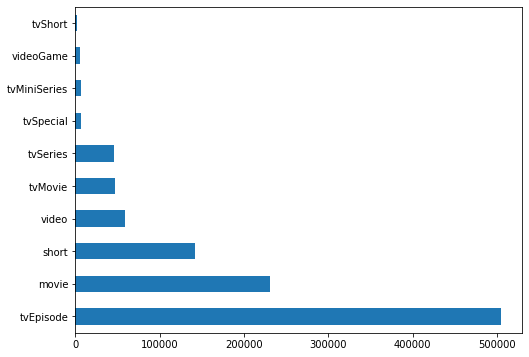

In [8]:
count_plot(titles, 'titleType')

In [9]:
print('Total of {} number of distinct genres combination'.format(titles['genres'].unique().shape[0]))

Total of 1731 number of distinct genres combination


In [10]:
titles['startYear'].value_counts()

2006    64078
2005    61789
2004    53015
2003    43672
2002    36430
        ...  
1890        3
1893        2
1888        2
1889        1
2023        1
Name: startYear, Length: 137, dtype: int64

In [11]:
titles[titles['startYear']=='2023']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
987260,tt10032644,movie,The Urn,The Urn,0,2023,\N,\N,Thriller


In [12]:
titles['endYear'].value_counts()

\N      1030298
2004        774
2005        768
2003        689
2001        663
         ...   
1945          1
2022          1
1938          1
1942          1
1933          1
Name: endYear, Length: 81, dtype: int64

In [13]:
titles[titles['endYear']=='1933']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
362034,tt0377269,tvSeries,The Television Ghost,The Television Ghost,0,1931,1933,15,Drama


In [15]:
titles[titles['runtimeMinutes']=='\\N'] # make sure to escape \ by adding another \

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
18,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,"Comedy,Short"
22,tt0000024,short,Opening of the Kiel Canal,Opening of the Kiel Canal,0,1895,\N,\N,"News,Short"
23,tt0000025,short,The Oxford and Cambridge University Boat Race,The Oxford and Cambridge University Boat Race,0,1895,\N,\N,"News,Short,Sport"
36,tt0000038,short,The Ball Game,The Ball Game,0,1898,\N,\N,"Documentary,Short,Sport"
37,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,\N,\N,Short
...,...,...,...,...,...,...,...,...,...
1048566,tt10140360,movie,Another Night in China,Another Night in China,1,2009,\N,\N,Adult
1048569,tt10140370,tvEpisode,Sarah Clifford,Sarah Clifford,0,2019,\N,\N,Talk-Show
1048571,tt10140378,tvEpisode,Corey Hart,Corey Hart,0,2019,\N,\N,Talk-Show
1048573,tt10140380,short,Fear of Dogs,Fear of Dogs,0,1994,\N,\N,"Drama,Short"


In this table, \N is treated as a null value so replace them for numeric values into nan

In [16]:
titles[titles['runtimeMinutes']=='\\N'].shape, titles[titles['startYear']=='\\N'].shape, titles[titles['endYear']=='\\N'].shape

((513537, 9), (9010, 9), (1030298, 9))

In [17]:
titles[titles['runtimeMinutes']!='\\N']['runtimeMinutes'].astype(int).min(), titles[titles['runtimeMinutes']!='\\N']['runtimeMinutes'].astype(int).max()

(0, 8400)

In [18]:
print('{:.2f}% of whole movies are adult videos'.format(titles['isAdult'].sum() / titles.shape[0] * 100))

4.07% of whole movies are adult videos


---

### Plots

In [19]:
plots.head()

,imdbID,title,year,rating,runtime,genre,released,director,writer,cast,metacritic,imdbRating,imdbVotes,poster,plot,fullplot,language,country,awards,lastupdated,type
0,1,Carmencita,1894,NOT RATED,1 min,"Documentary, Short",NaN,William K.L. Dickson,NaN,Carmencita,NaN,5.9,1032.0,https://m.media-amazon.com/images/M/MV5BMjAzND...,Performing on what looks like a small wooden s...,Performing on what looks like a small wooden s...,NaN,USA,NaN,2015-08-26 00:03:45.040000000,movie
1,5,Blacksmith Scene,1893,UNRATED,1 min,Short,1893-05-09,William K.L. Dickson,NaN,"Charles Kayser, John Ott",NaN,6.2,1189.0,NaN,Three men hammer on an anvil and pass a bottle...,A stationary camera looks at a large anvil wit...,NaN,USA,1 win.,2015-08-26 00:03:50.133000000,movie
2,3,Pauvre Pierrot,1892,NaN,4 min,"Animation, Comedy, Short",1892-10-28,�mile Reynaud,NaN,NaN,NaN,6.7,566.0,NaN,"One night, Arlequin come to see his lover Colo...","One night, Arlequin come to see his lover Colo...",NaN,France,NaN,2015-08-12 00:06:02.720000000,movie
3,8,Edison Kinetoscopic Record of a Sneeze,1894,NaN,1 min,"Documentary, Short",1894-01-09,William K.L. Dickson,NaN,Fred Ott,NaN,5.9,988.0,NaN,A man (Thomas Edison's assistant) takes a pinc...,A man (Edison's assistant) takes a pinch of sn...,NaN,USA,NaN,2015-08-10 00:21:07.127000000,movie
4,10,Employees Leaving the Lumi�re Factory,1895,NaN,1 min,"Documentary, Short",1895-03-22,Louis Lumi�re,NaN,NaN,NaN,6.9,3469.0,NaN,A man opens the big gates to the Lumi�re facto...,A man opens the big gates to the Lumi�re facto...,NaN,France,NaN,2015-08-26 00:03:56.603000000,movie


In [20]:
plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46014 entries, 0 to 46013
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imdbID       46014 non-null  int64  
 1   title        46014 non-null  object 
 2   year         46014 non-null  object 
 3   rating       24629 non-null  object 
 4   runtime      43377 non-null  object 
 5   genre        45615 non-null  object 
 6   released     43002 non-null  object 
 7   director     45409 non-null  object 
 8   writer       42942 non-null  object 
 9   cast         44928 non-null  object 
 10  metacritic   9401 non-null   float64
 11  imdbRating   44300 non-null  float64
 12  imdbVotes    44299 non-null  float64
 13  poster       35798 non-null  object 
 14  plot         42161 non-null  object 
 15  fullplot     41421 non-null  object 
 16  language     44899 non-null  object 
 17  country      45830 non-null  object 
 18  awards       23542 non-null  object 
 19  last

Because we already have most of the columns, extract only the following selected columns to use

In [21]:
cols_to_use = ['imdbID', 'plot', 'fullplot', 'awards', 'country']
plots = plots[cols_to_use]

In [22]:
plots.head()

,imdbID,plot,fullplot,awards,country
0,1,Performing on what looks like a small wooden s...,Performing on what looks like a small wooden s...,NaN,USA
1,5,Three men hammer on an anvil and pass a bottle...,A stationary camera looks at a large anvil wit...,1 win.,USA
2,3,"One night, Arlequin come to see his lover Colo...","One night, Arlequin come to see his lover Colo...",NaN,France
3,8,A man (Thomas Edison's assistant) takes a pinc...,A man (Edison's assistant) takes a pinch of sn...,NaN,USA
4,10,A man opens the big gates to the Lumi�re facto...,A man opens the big gates to the Lumi�re facto...,NaN,France


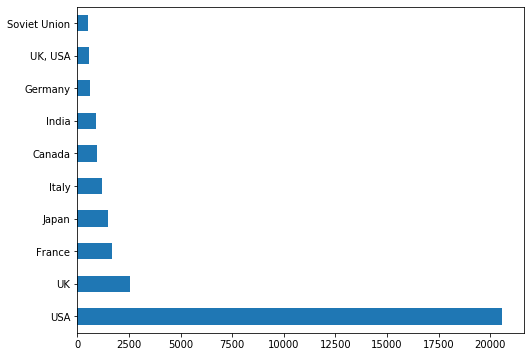

In [23]:
count_plot(plots, 'country')

We can see that there are movies having country of "UK, USA". 

In [24]:
plots[plots['country']=='UK, USA']

,imdbID,plot,fullplot,awards,country
3126,40321,Uncle Rollo finally retires to the house he wa...,Uncle Rollo finally retires to the house he wa...,NaN,"UK, USA"
3129,40325,"Matt Denant, ex-RAF flier, sentenced to three ...",NaN,NaN,"UK, USA"
3286,41329,Arnold Boult is determined to make his son a s...,Arnold Boult is determined to make his son a s...,Nominated for 1 Oscar. Another 1 nomination.,"UK, USA"
3517,42757,"In 1875 London, young Wheeler (who lives by sc...","In 1875 London, young Wheeler (who lives by sc...",NaN,"UK, USA"
3576,43067,The treasure seeking adventures of young Jim H...,Enchanted by the idea of locating treasure bur...,1 nomination.,"UK, USA"
...,...,...,...,...,...
44355,3798628,Follows comedian/author/activist Russell Brand...,Follows comedian/author/activist Russell Brand...,1 win.,"UK, USA"
44505,3890160,After being coerced into working for a crime b...,After being coerced into working for a crime b...,NaN,"UK, USA"
44706,4008652,Unprecedented access to Muhammad Ali's persona...,An intimate and heart-warming look at the man ...,2 nominations.,"UK, USA"
45511,4547056,A scientist and a teacher living in a dystopia...,A scientist and a teacher living in a dystopia...,NaN,"UK, USA"


Because country can have more than one value delimited by a comma, we will split them and apply One-Hot-Encoding as numeric features, columns being unique country value. The value will be 1 if a country appears in that row, 0 if not. It's better than using string value

In [25]:
print('longest number of characters in plot columns is {}'.format(plots['plot'].str.len().max()))
print('longest number of characters in fullplot columns is {}'.format(plots['fullplot'].str.len().max()))

longest number of characters in plot columns is 402.0
longest number of characters in fullplot columns is 9097.0


---

### Ratings

In [26]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1694
1,tt0000002,6.0,210
2,tt0000003,6.5,1441
3,tt0000004,6.1,122
4,tt0000005,6.1,2240


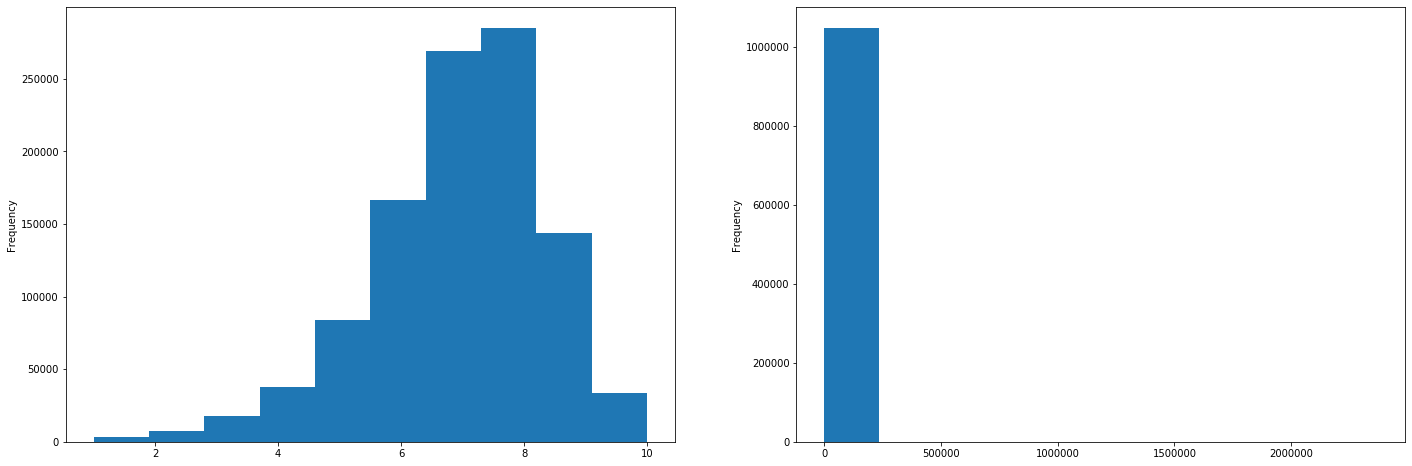

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ratings['averageRating'].plot(kind='hist', ax=ax[0])
ratings['numVotes'].plot(kind='hist', ax=ax[1])

plt.show();

**numVotes** in ratings are highly skewed, possibly due to outlier

In [28]:
ratings['numVotes'].describe()

count    1.048575e+06
mean     1.006758e+03
std      1.669461e+04
min      5.000000e+00
25%      9.000000e+00
50%      2.000000e+01
75%      8.000000e+01
max      2.369294e+06
Name: numVotes, dtype: float64

Examine movies having less than 100 votes

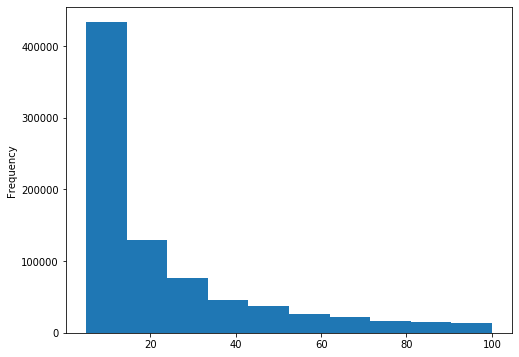

In [29]:
plt.figure(figsize=(8, 6))
ratings[ratings['numVotes']<=100]['numVotes'].plot(kind='hist')

---

### Netflix

In [30]:
netflix.shape

(7787, 12)

In [31]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,14-Aug-20,2020,TV-MA,4,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,15-Dec-17,2008,TV-MA,143,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...
2,s100,Movie,3 Heroines,Iman Brotoseno,"Reza Rahadian, Bunga Citra Lestari, Tara Basro...",Indonesia,5-Jan-19,2016,TV-PG,124,"Dramas, International Movies, Sports Movies",Three Indonesian women break records by becomi...
3,s1000,Movie,Blue Mountain State: The Rise of Thadland,Lev L. Spiro,"Alan Ritchson, Darin Brooks, James Cade, Rob R...",United States,1-Mar-16,2016,R,90,Comedies,New NFL star Thad buys his old teammates' belo...
4,s1001,TV Show,Blue Planet II,NaN,David Attenborough,United Kingdom,3-Dec-18,2017,TV-G,1,"British TV Shows, Docuseries, Science & Nature TV",This sequel to the award-winning nature series...


In [32]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   int64 
 10  genres        7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(2), object(10)
memory usage: 730.2+ KB


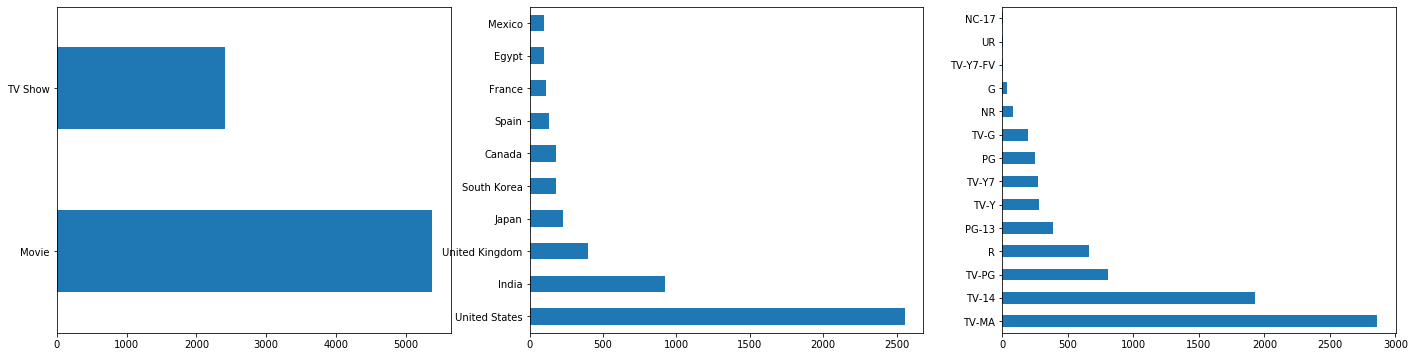

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

netflix['type'].value_counts().plot(kind='barh', ax=ax[0])
netflix['country'].value_counts()[:10].plot(kind='barh', ax=ax[1])
netflix['rating'].value_counts().plot(kind='barh', ax=ax[2])

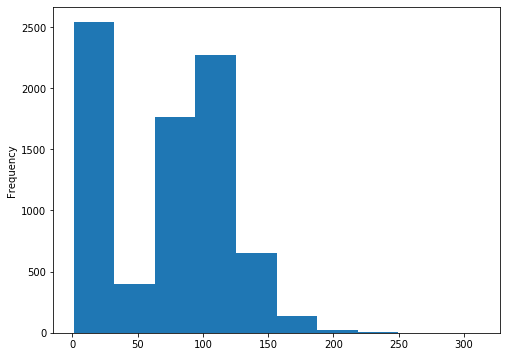

In [34]:
plt.figure(figsize=(8, 6))
netflix['duration'].plot(kind='hist')
plt.show();

Again, just like IMDB titles, their runtime/duration is not normally distributed. Either standardizing or normalizing could help the performance later.